# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 6 : Modèles bayésiens pour la loi normale

Dans ce chapitre, nous utiliserons le jeu de données *illingworth1927.csv* disponible sur le site web du cours. Ces données proviennent de l'expérience de Michelson-Morley effectuée par Illingworth en 1927 dans le but de mesurer la différence de la vitesse de la lumière dans deux directions orthogonales, dont l'une des directions est parallèle à la vitesse de l'éther et l'autre est orthogonale. La différence de vitesse a été mesurée par interférométrie en calculant le déplacement des franges d'interférence. Les deux premières colonnes indiquent les conditions expérimentales et la colonne :FringeDispl contient le déplacement des franges d'interférence en millième.


In [1]:
# Chargement des librairies
using CSV, DataFrames             # Pour charger et organiser les données
using Gadfly                      # Pour générer des graphiques
using LinearAlgebra               # Pour utiliser les fonctions d'algèbre linéaire
using Statistics                  # Libriairie contenant des fonctions statistiques de base
using Distributions               # Librairie contenant les lois statistiques

In [2]:
# using Cairo, Fontconfig           # Pour sauvegarder les figures en pdf

## 5.0 Chargement des données et analyse exploratoire

In [3]:
# Chargement des observations effectuées par Illingworth en 1927 sur l'expérience de Michelson-Morley

data = CSV.read("illingworth1927.csv", DataFrame)
first(data,5)

,Time,Direction,Weights,FringeDispl,Speed
,String7,String3,Float64,Float64,Float64
1,5 a.m.,N,0.12,0.24,1.7351
2,5 a.m.,NW,-0.33,-0.66,-2.87733
3,11 a.m.,N,0.35,0.7,2.96324
4,11 a.m.,NW,-0.11,-0.22,-1.66123
5,5 p.m.,N,0.12,0.24,1.7351


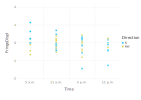

In [4]:
fig = plot(data, x=:Time, y=:FringeDispl, color=:Direction, Geom.point)
# draw(PDF("illingworth1927.pdf"), fig)

### Sélection des observations effectuées à 5 a.m. dans la direction N (Tableau 5.1 des notes)

In [5]:
df = filter(row -> (row.Time == "5 a.m.") & (row.Direction =="N"), data )

,Time,Direction,Weights,FringeDispl,Speed
,String7,String3,Float64,Float64,Float64
1,5 a.m.,N,0.12,0.24,1.7351
2,5 a.m.,N,0.57,1.14,3.78156
3,5 a.m.,N,0.0,0.0,0.0
4,5 a.m.,N,0.1,0.2,1.58392
5,5 a.m.,N,0.32,0.64,2.8334
6,5 a.m.,N,-0.01,-0.02,-0.500879


In [6]:
y = df.FringeDispl
n = length(y)
ȳ = mean(y)
s = std(y)

println("Il y a $n observations et le déplacement moyen est de $ȳ.")

Il y a 6 observations et le déplacement moyen est de 0.36666666666666664.


## 6.2 Loi *a priori* informative

On utilise ici la loi *a priori* partiellement informative présentée dans les notes de cours.

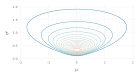

In [7]:
# Hyperparamètres de la loi a priori
ν = 0
α = 1
β = 1

f(μ::Real, σ²::Real) = pdf(Normal(ν,σ²), μ) * pdf(InverseGamma(α,β), σ²)
set_default_plot_size(14cm, 8cm)
fig = plot(z=(x,y) -> f(x,y),
        xmin=[-2], xmax=[2], ymin=[.01], ymax=[2], Geom.contour,
        Theme(key_position = :none), Guide.xlabel("μ"), Guide.ylabel("σ²"))
# draw(PDF("prior.pdf"), fig)

### Loi *a posteriori* correspondante

On calcule la forme fonctionnelle de la loi *a posteriori* correspondante. Attention, cette loi n'est pas normalisée, le graphique n'est qu'une indication visuelle.

In [8]:
f(μ::Real, σ²::Real) = exp(loglikelihood(Normal(μ,σ²),y) + logpdf(Normal(ν,σ²), μ)  + logpdf(InverseGamma(α,β), σ²))

f (generic function with 1 method)

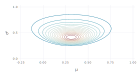

In [9]:
set_default_plot_size(14cm, 8cm)
fig = plot(z=(x,y) -> f(x,y),
        xmin=[-3], xmax=[3], ymin=[.01], ymax=[1], Geom.contour,
        Coord.cartesian(xmin=-.25, xmax=1), Guide.xticks(ticks=-.25:.25:1),
        Theme(key_position = :none), Guide.xlabel("μ"), Guide.ylabel("σ²"))
# draw(PDF("posterior.pdf"), fig)

### Echantillonnage de la loi *a posteriori*

Implémentation de l'échantillonnage de Gibbs pour générer un échantillon de la loi *a posteriori*.

In [10]:
# Définition des deux lois conditionnelles complètes
f₁(σ²::Real) = Normal((n*ȳ + ν)/(n+1), sqrt(σ²/n+1))
f₂(μ::Real) = InverseGamma(α + (n+1)/2, β + .5*(μ - ν)^2 + .5*sum((y .- μ).^2) )

f₂ (generic function with 1 method)

In [11]:
m = 1000

μ = Array{Float64}(undef,m)
σ² = Array{Float64}(undef,m)

μ[1] = 10
σ²[1] = 100

for t in 2:m
    μ[t] = rand(f₁(σ²[t-1]))
    σ²[t] = rand(f₂(μ[t]))
end

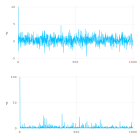

In [12]:
fig1 = plot(y=μ, Geom.line)
fig2 = plot(y=σ², Geom.line)

set_default_plot_size(14cm, 14cm)
vstack([fig1;fig2])

In [13]:
# Récupération de la phase d'échantillonnage
deleteat!(μ, 1:100)
deleteat!(σ², 1:100)

900-element Vector{Float64}:
 1.8483660870941665
 1.0560985788027963
 0.8244795523992956
 0.4607736347185719
 1.00325557877908
 0.5268348215576082
 0.30215701705617876
 0.9841850195773474
 0.867945329398188
 0.47815557027538674
 ⋮
 0.6170346317352302
 1.5474362090059905
 0.6456403214283625
 0.5955132541873596
 1.1377315046353553
 2.10677961001137
 2.079871115681854
 2.042180386840571
 0.9379020895819394

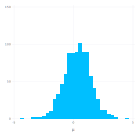

In [14]:
# Loi marginale de μ
plot(x=μ, Geom.histogram(bincount=30), Guide.xlabel("μ"))

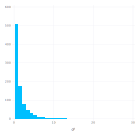

In [15]:
# Loi marginale de σ²
plot(x=σ², Geom.histogram(bincount=30), Guide.xlabel("σ²"))

## 6.5 Comparaison de modèle

Calcul du BIC

In [16]:
# calcul du maximum de la vraisemblance
fd = fit(Normal, y)

# calcul du BIC
k=2 # nb de paramètres
bic = loglikelihood(fd,y) - k/2*log(n)

-4.931711834256902